# Deep Learning Basics with PyTorch
# Part I — Foundations of Machine Learning
## Chapter 4 — The Limits of Classical ML

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')  # plotting
%config InlineBackend.figure_format = 'retina'

In [2]:
# ==============================================================
# 1. Load ADR Dataset and Build Features (Chronologically Indexed)
# ==============================================================

# Load ADR data
df = pd.read_csv("adr_prices_and_vol.csv", parse_dates=["Date"])
ticker = "CIB"

# Select relevant columns and drop missing data
df_t = df[["Date", f"{ticker}_Price", f"{ticker}_Volume"]].dropna().copy()
df_t.set_index("Date", inplace=True)  #  Ensure time-based indexing

# Compute daily returns and volume changes
df_t["Return_1d"] = df_t[f"{ticker}_Price"].pct_change()
df_t["VolChange"] = df_t[f"{ticker}_Volume"].pct_change()

# Compute 5-day returns and rolling volatility
df_t["Return_5d"] = df_t[f"{ticker}_Price"].pct_change(5)
df_t["Volatility_5d"] = df_t["Return_1d"].rolling(5).std()

# Drop missing values after feature creation
df_t.dropna(inplace=True)

# Binary target: 1 = Up day, 0 = Down day
df_t["Target"] = (df_t["Return_1d"].shift(-1) > 0).astype(int)

df_t.dropna(inplace=True)

# Preview last few rows
df_t.tail()

,CIB_Price,CIB_Volume,Return_1d,VolChange,Return_5d,Volatility_5d,Target
Date,,,,,,,
2025-07-08,44.93,124200,0.000000,-0.178028,-0.027279,0.014311,1
2025-07-09,44.96,261800,0.000668,1.107890,-0.016623,0.014234,0
2025-07-10,44.70,193200,-0.005783,-0.262032,-0.035807,0.010494,0
2025-07-11,44.23,188800,-0.010515,-0.022774,-0.040356,0.010547,1
2025-07-14,44.78,136722,0.012435,-0.275837,-0.003339,0.008617,0


In [3]:
X = df_t[["Return_1d", "VolChange"]].values
y = df_t["Target"].values

# Distance concentration

Using 2547 samples and 24 features.


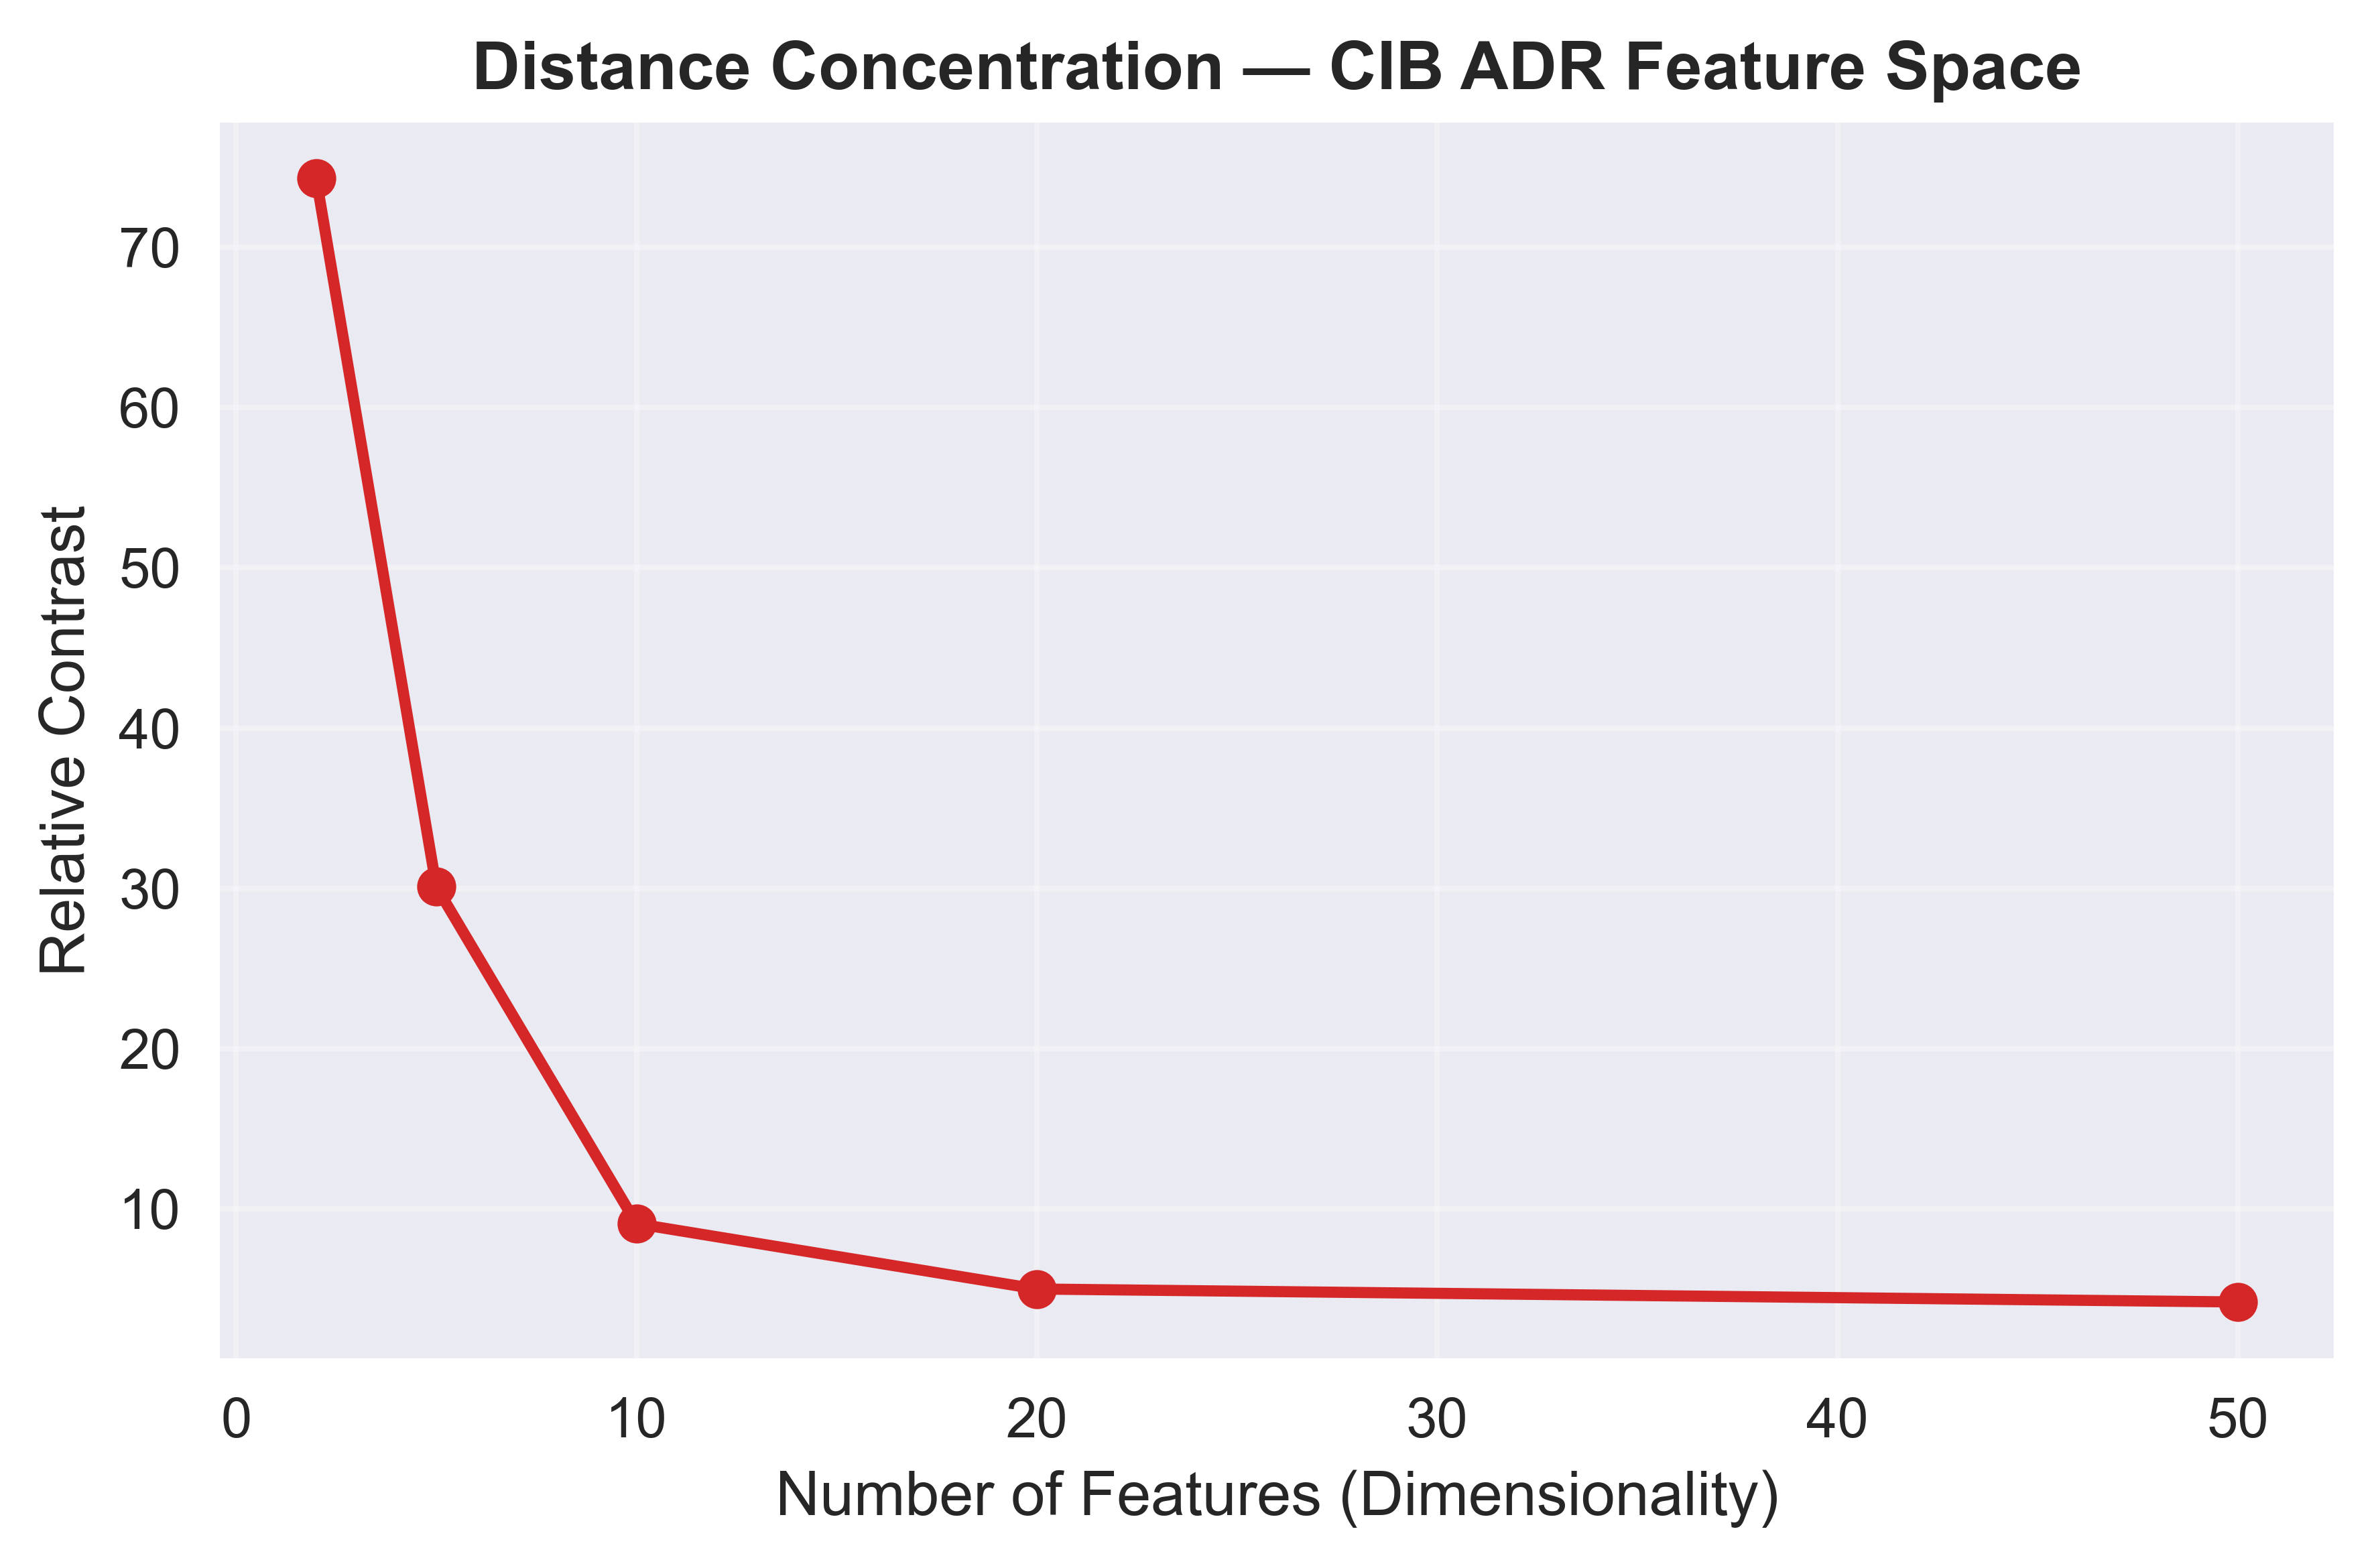

In [4]:
# ==============================================================
# 2. Distance Concentration (CIB ADR + Synthetic Expansion)
# ==============================================================

from sklearn.preprocessing import StandardScaler

rng = np.random.default_rng(42)

# --------------------------------------------------------------
# 1. Base Features from Real ADR Data
# --------------------------------------------------------------
features_core = ["Return_1d", "VolChange", "Return_5d", "Volatility_5d"]
df_features = df_t[features_core].copy()

# --------------------------------------------------------------
# 2. Synthetic Expansion — Lagged and Noise Features
#    (simulate high-dimensional noisy financial feature space)
# --------------------------------------------------------------
# Add lagged returns (simulate memory effects)
for lag in [2, 3, 4, 5, 10]:
    df_features[f"Return_Lag{lag}"] = df_t["Return_1d"].shift(lag)

# Add random noise features (simulate spurious signals)
for i in range(6, 21):  # creates Noise_6 … Noise_20
    df_features[f"Noise_{i}"] = rng.normal(0, 0.01, len(df_t))

# Drop missing values due to lagging
df_features.dropna(inplace=True)

# --------------------------------------------------------------
# 3. Prepare Feature Matrix
# --------------------------------------------------------------
X_full = StandardScaler().fit_transform(df_features.values)
n_samples, n_features = X_full.shape
print(f"Using {n_samples} samples and {n_features} features.")

# --------------------------------------------------------------
# 4. Distance Concentration Computation
# --------------------------------------------------------------
dims = np.array([2, 5, 10, 20, 50])  # evaluate up to 50 dimensions
n_points = min(500, n_samples)
n_subsample = 60
rel = []

sub_idx = rng.choice(n_samples, size=n_points, replace=False)

for d in dims:
    X = X_full[sub_idx, :d]
    mins, maxs = [], []
    idx = rng.choice(n_points, size=n_subsample, replace=False)
    
    for i in idx:
        diffs = X - X[i]
        dists = np.sqrt(np.sum(diffs * diffs, axis=1))
        dists = dists[dists > 0]
        mins.append(dists.min())
        maxs.append(dists.max())
    
    rel_contrast = (np.mean(maxs) - np.mean(mins)) / np.mean(mins)
    rel.append(rel_contrast)

# --------------------------------------------------------------
# 5. Plot: Publication-Grade Visualization
# --------------------------------------------------------------
plt.figure(figsize=(6, 4), dpi=300)
plt.plot(dims, rel, marker='o', color='tab:red', linewidth=2)
plt.xlabel('Number of Features (Dimensionality)', fontsize=11)
plt.ylabel('Relative Contrast', fontsize=11)
plt.title(f'Distance Concentration — {ticker} ADR Feature Space', fontsize=12, weight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Interpretation 

- As dimensionality grows from 2 → 50, the relative contrast collapses rapidly — confirming that distances become almost indistinguishable.

- In this simulated high-dimensional financial feature space, “closeness” loses meaning — a hallmark of the curse of dimensionality.

- This explains why classical distance-based algorithms (e.g., kNN, RBF-SVM, clustering) degrade as features expand without careful dimensionality control.

- In practice, this motivates the use of representation learning or autoencoders to restore structure before applying predictive models.

## Polynomial feature growth

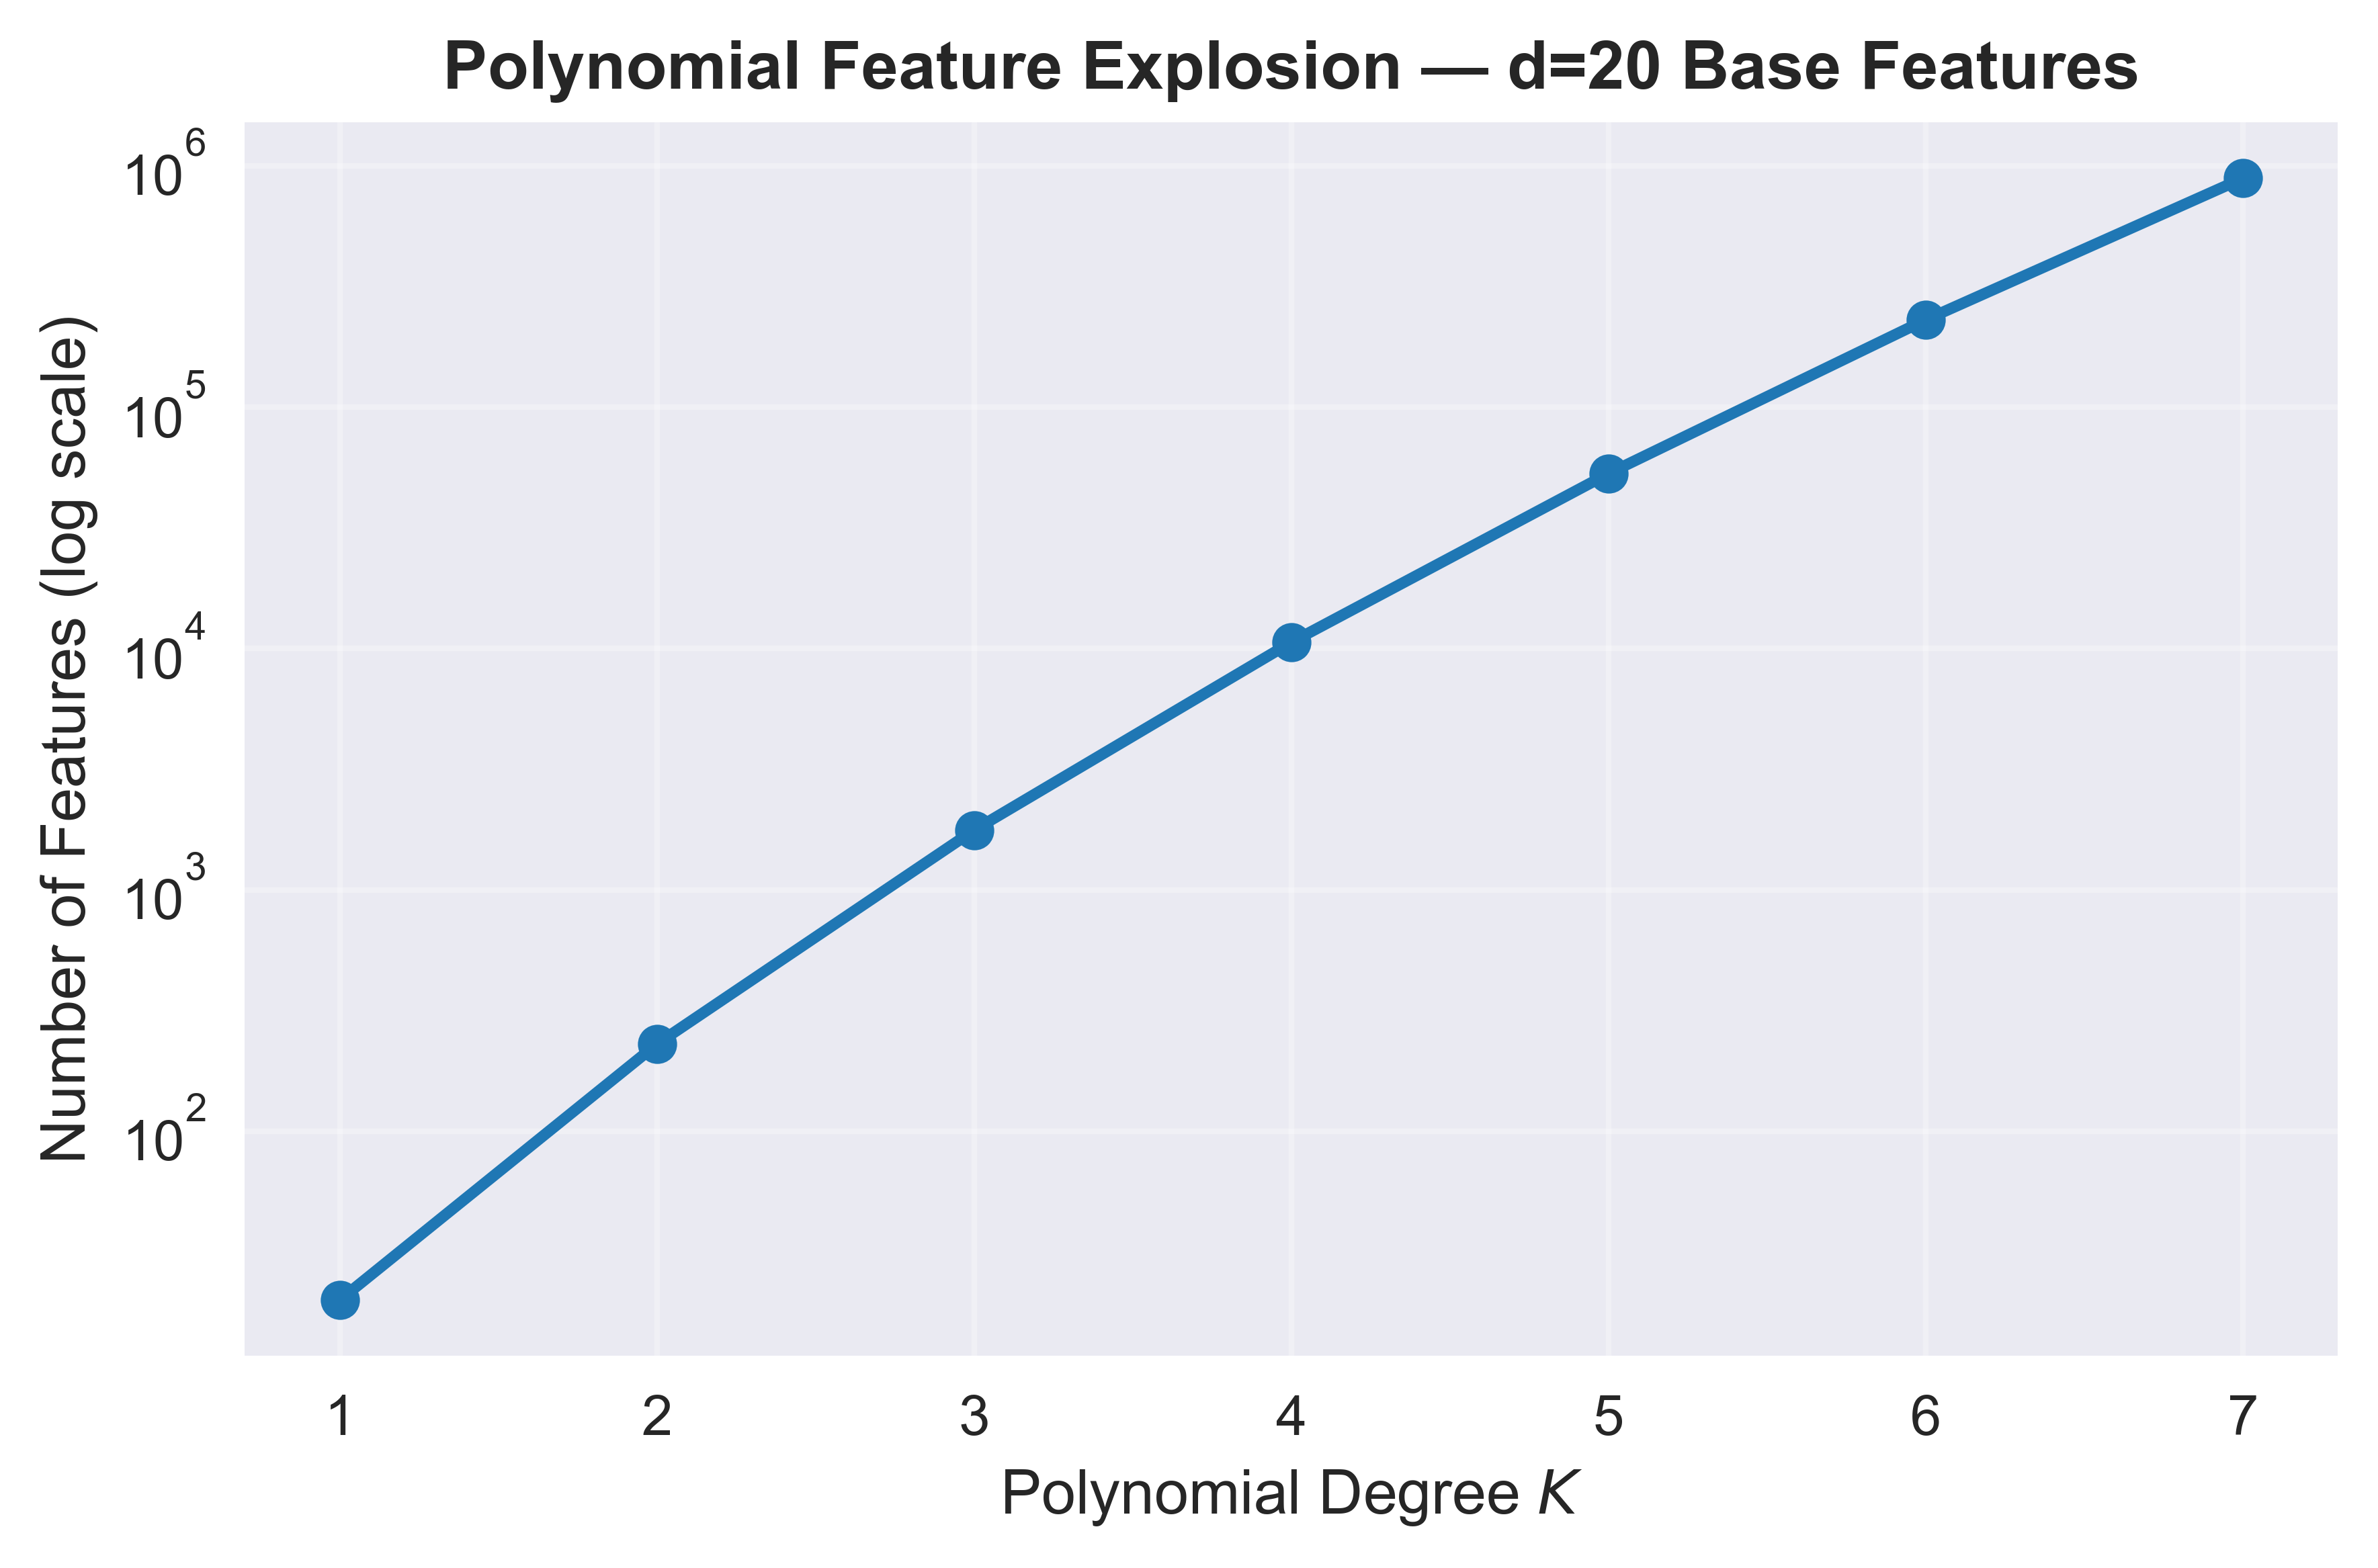

In [5]:
# ==============================================================
# 3. Feature Explosion in Polynomial Models
# ==============================================================

import math

# --------------------------------------------------------------
# 1. Helper function: count polynomial feature combinations
# --------------------------------------------------------------
def poly_count(d, K):
    """
    Computes the total number of polynomial features (excluding bias)
    generated by a PolynomialFeatures transformer of degree K
    given d original features.

    Formula: sum_{k=1}^{K} C(d + k - 1, k)
    """
    return sum(math.comb(d + k - 1, k) for k in range(1, K + 1))

# --------------------------------------------------------------
# 2. Define number of base features (d) and degrees (K)
# --------------------------------------------------------------
d = 20                        # number of original features (e.g., financial indicators)
Ks = np.arange(1, 8)          # polynomial degrees 1 → 7
counts = [poly_count(d, int(K)) for K in Ks]

# --------------------------------------------------------------
# 3. Plot (log scale to visualize explosion)
# --------------------------------------------------------------
plt.figure(figsize=(6, 4), dpi=300)
plt.plot(Ks, counts, marker='o', color='tab:blue', linewidth=2)
plt.yscale('log')
plt.xlabel('Polynomial Degree $K$', fontsize=11)
plt.ylabel('Number of Features (log scale)', fontsize=11)
plt.title(f'Polynomial Feature Explosion — d={d} Base Features', fontsize=12, weight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Interpretation 

- With only 20 original features, adding polynomial combinations up to degree 7 generates tens of millions of terms — even before training starts.

- This illustrates the combinatorial explosion of features when classical ML tries to model non-linearity through explicit polynomial expansion.

- Financial data, which is already noisy and correlated, becomes numerically unstable under such dimensional blow-ups.

- Deep learning solves this by learning hierarchical non-linear mappings implicitly, without enumerating all interaction terms.

## Kernel scaling (n^2 memory)

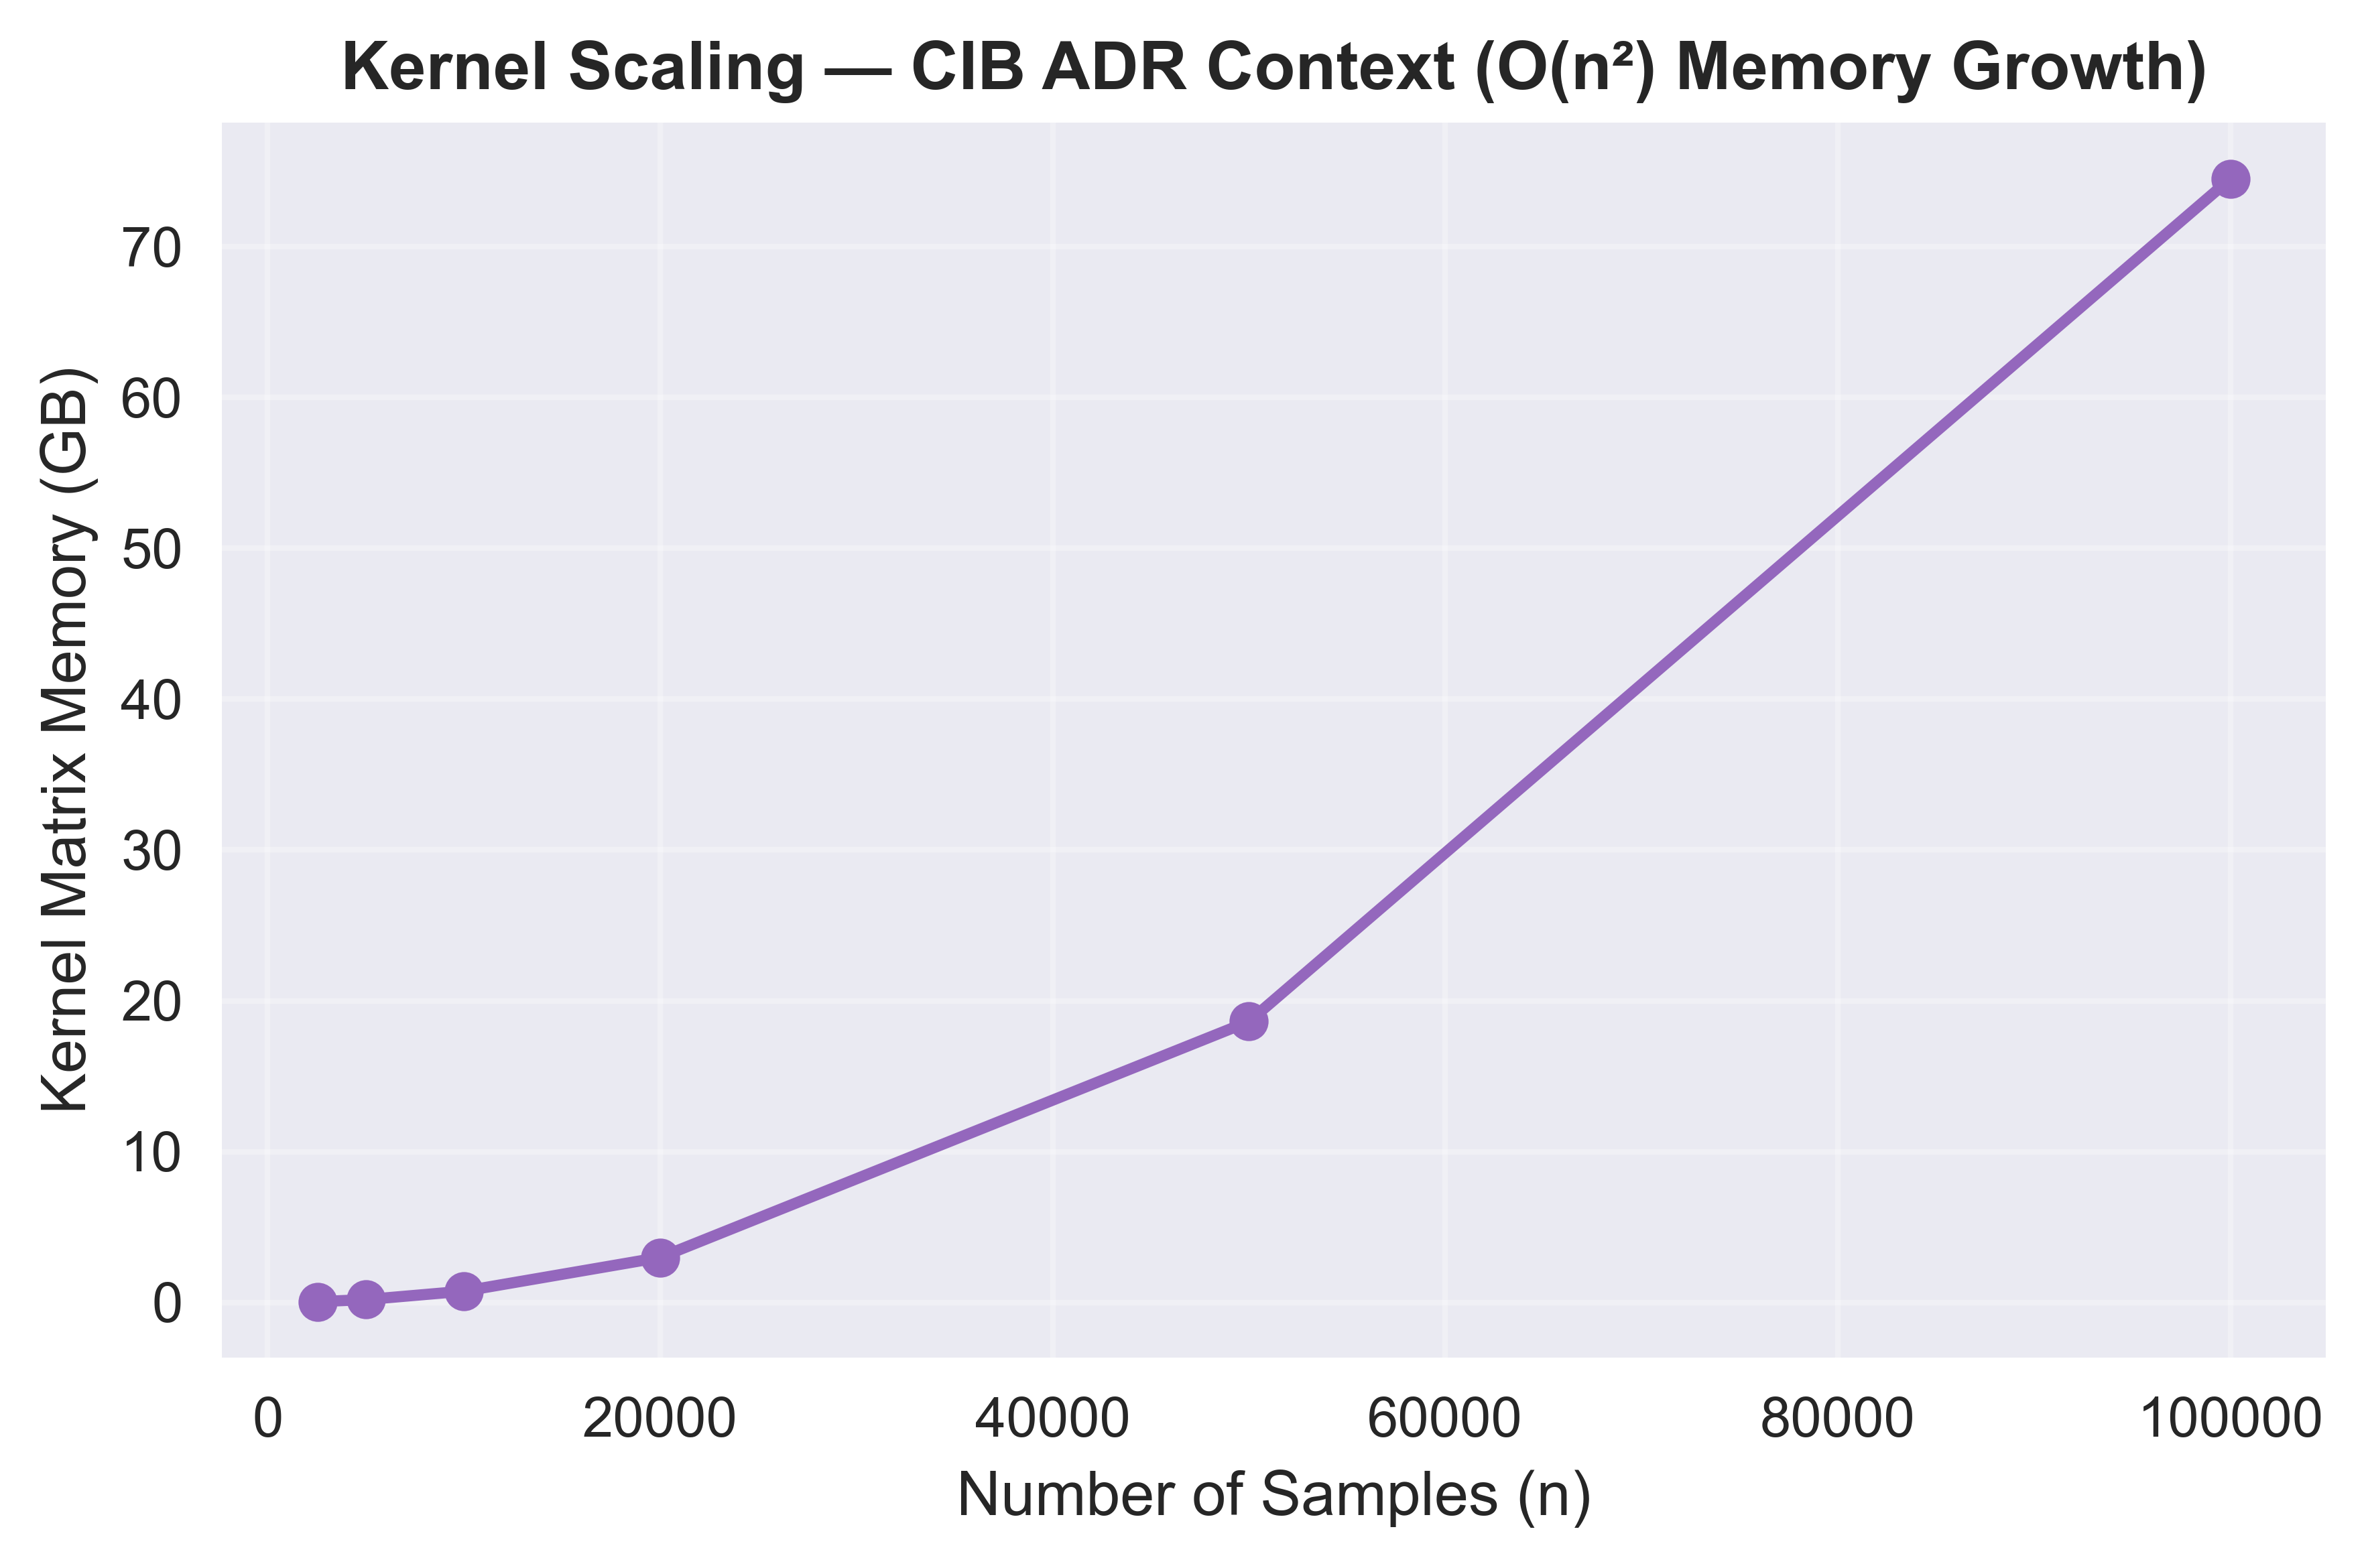

  2,557 samples →  0.049 GB
  5,000 samples →  0.186 GB
 10,000 samples →  0.745 GB
 20,000 samples →  2.980 GB
 50,000 samples → 18.626 GB
100,000 samples → 74.506 GB


In [6]:
# ==============================================================
# 4. Kernel Scaling and Memory Growth (O(n²))
# CIB ADR Context — sample scaling with realistic dataset sizes
# ==============================================================

# --- Start from actual CIB ADR dataset size
n_real = len(df_t)
n = np.array([n_real, 5000, 10000, 20000, 50000, 100000])
mem_gb = (n.astype(float)**2 * 8) / (1024**3)  # float64 (8 bytes per entry)

# --- Plot
plt.figure(figsize=(6, 4), dpi=300)
plt.plot(n, mem_gb, marker='o', color='tab:purple', linewidth=2)
plt.xlabel('Number of Samples (n)', fontsize=11)
plt.ylabel('Kernel Matrix Memory (GB)', fontsize=11)
plt.title(f'Kernel Scaling — CIB ADR Context (O(n²) Memory Growth)', fontsize=12, weight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

for size, mem in zip(n, mem_gb):
    print(f"{int(size):>7,} samples → {mem:>6.3f} GB")

## Interpretation

- Our CIB ADR dataset (around 2.5 k samples) fits easily in memory (around 0.05 GB).

- But scaling to 50 k – 100 k samples (e.g., multi-asset or intraday data) would push kernel memory into 10–80 GB range — infeasible on most systems.

- This shows why kernel SVMs and Gaussian Processes are rarely used in
modern asset management pipelines with high-frequency or cross-sectional data.

- Deep learning, by contrast, uses mini-batches and scales linearly in n, making it suitable for large time-series universes.

## Complexity vs depth (Decision Tree)

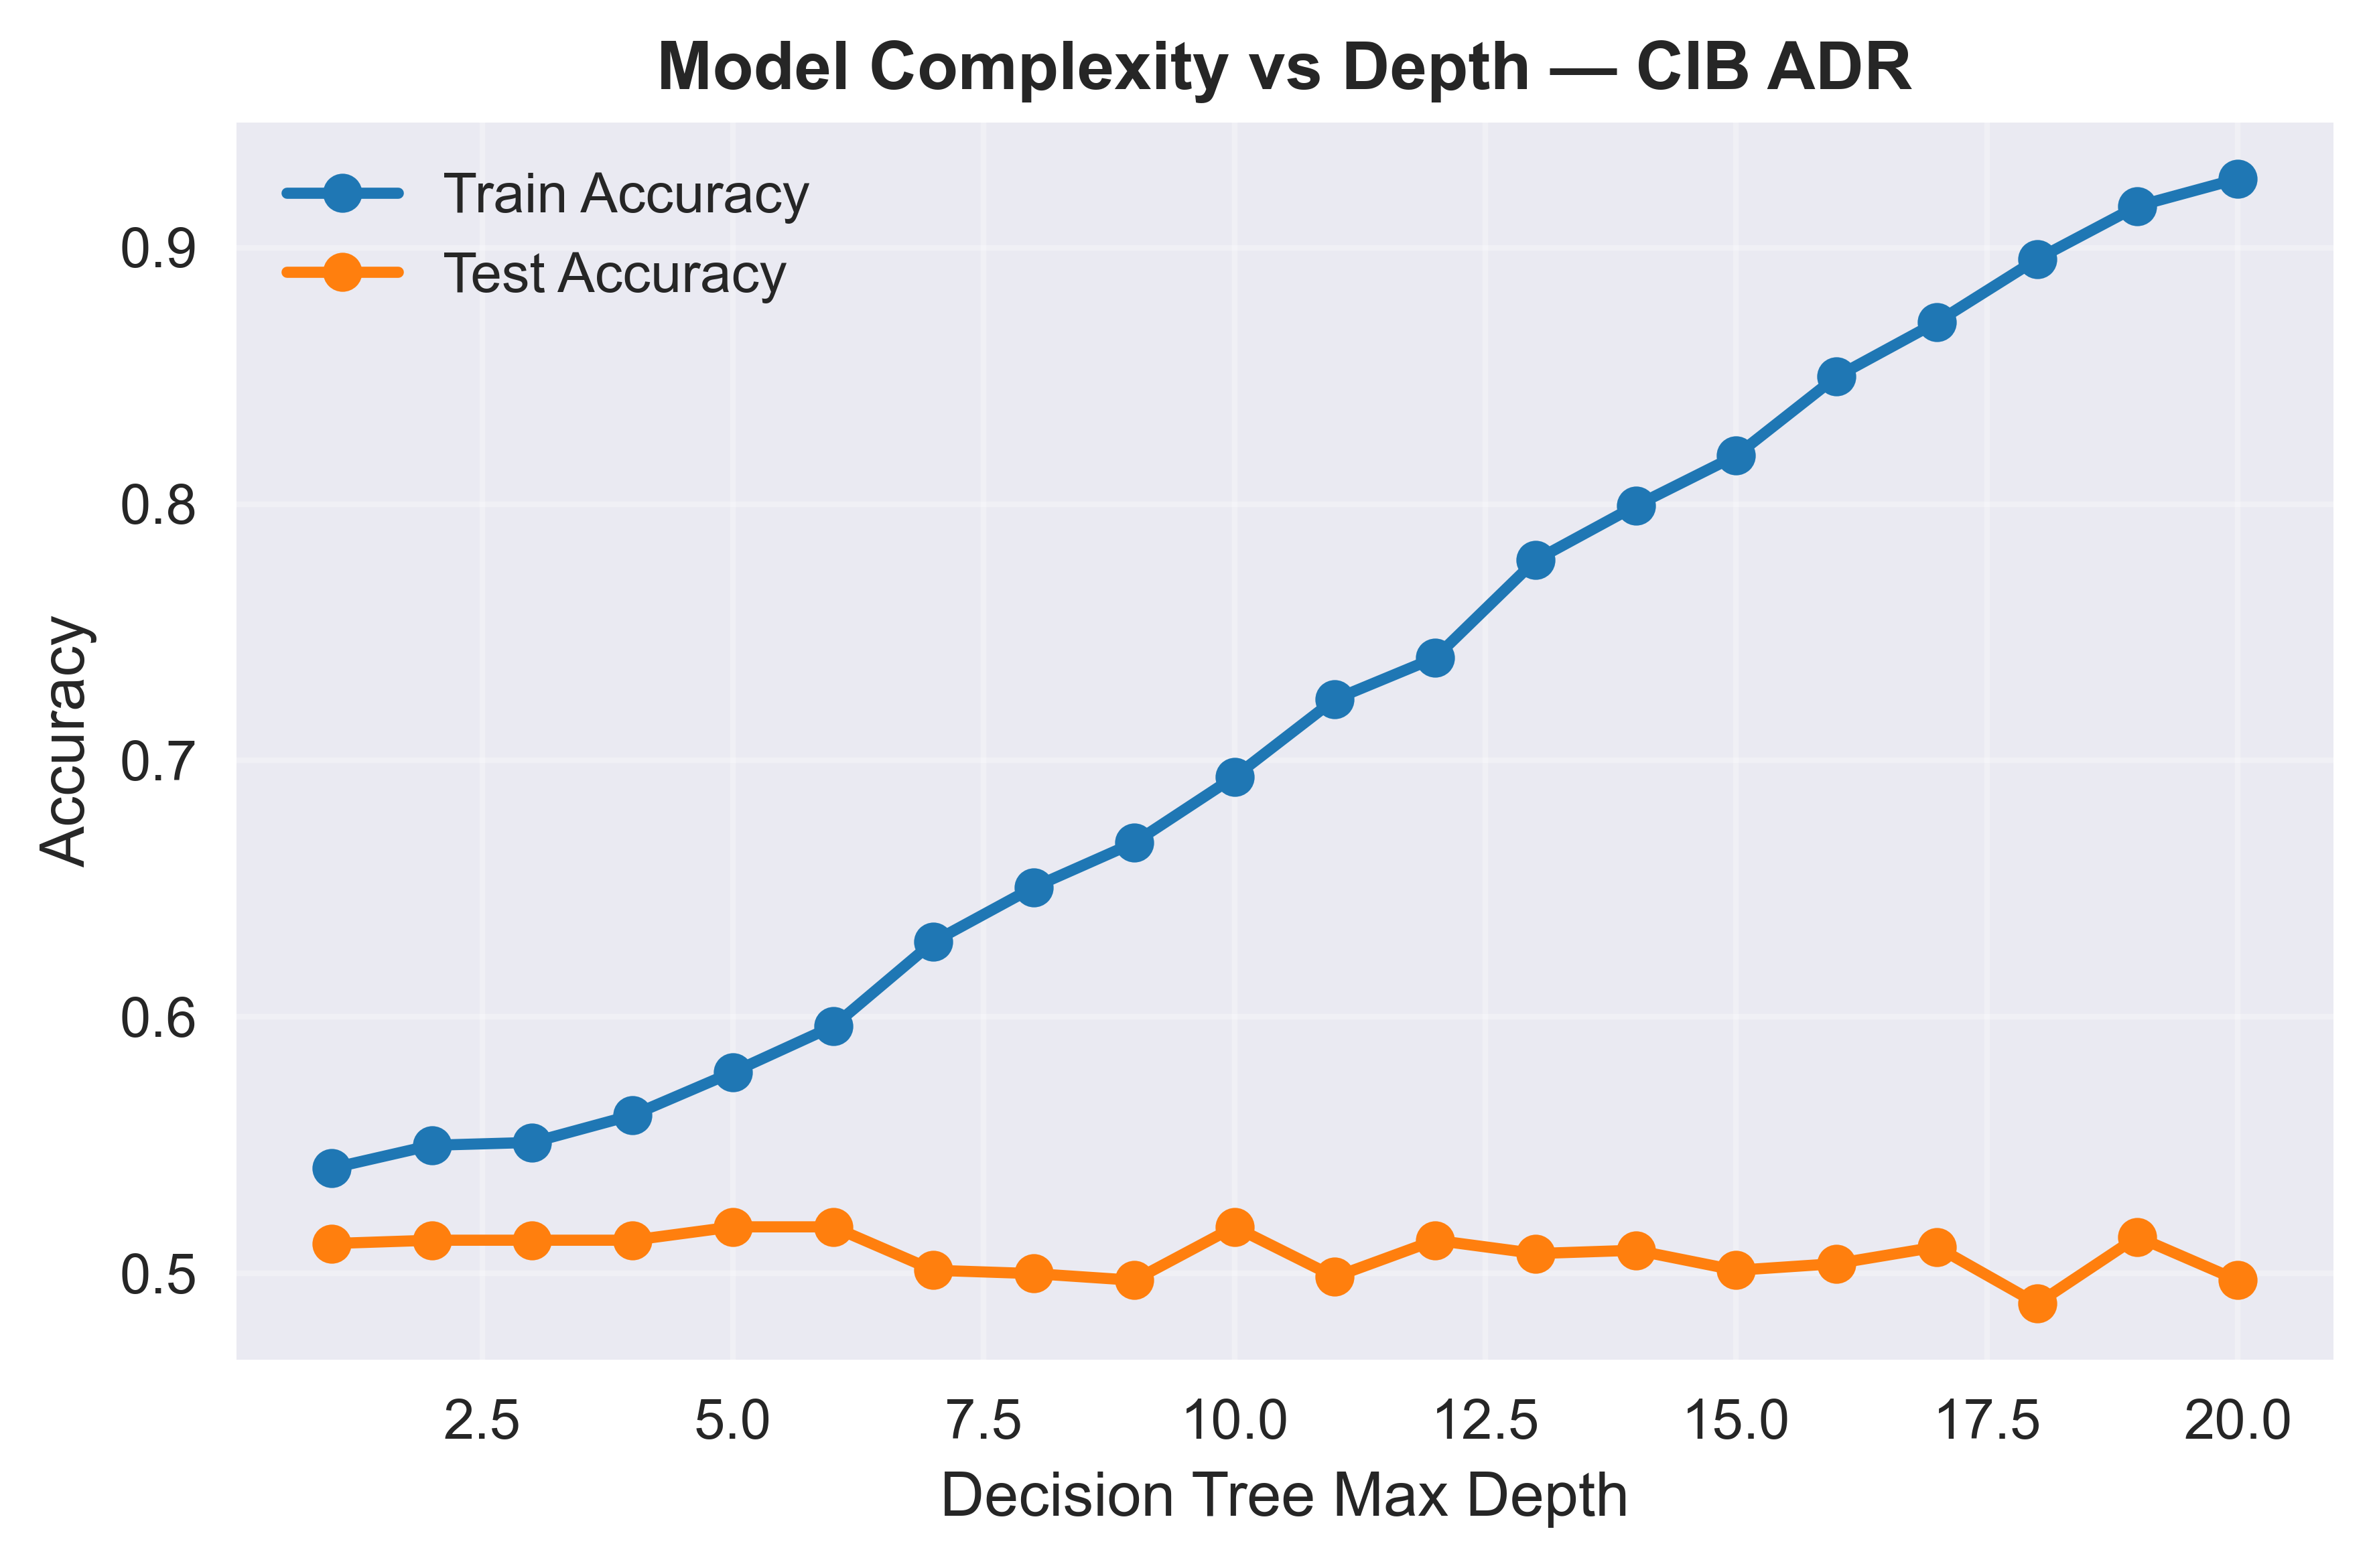

Best test accuracy: 0.518 at depth = 5


In [7]:
# ==============================================================
# 5. Decision Tree Complexity vs Depth (CIB ADR)
# ==============================================================

from sklearn.tree import DecisionTreeClassifier

# --------------------------------------------------------------
# 1. Prepare Data
# --------------------------------------------------------------
# Use existing engineered features
features = ["Return_1d", "VolChange", "Return_5d", "Volatility_5d"]
X = df_t[features].values
y = df_t["Target"].values

# Chronological split (70/30) to preserve time order
split_idx = int(0.7 * len(df_t))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Standardize features
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# --------------------------------------------------------------
# 2. Train Decision Trees of increasing depth
# --------------------------------------------------------------
depths = range(1, 21)
train_acc, test_acc = [], []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    clf.fit(X_train, y_train)
    train_acc.append(clf.score(X_train, y_train))
    test_acc.append(clf.score(X_test, y_test))

# --------------------------------------------------------------
# 3. Plot: Model Complexity vs Accuracy
# --------------------------------------------------------------
plt.figure(figsize=(6, 4), dpi=300)
plt.plot(depths, train_acc, marker='o', label='Train Accuracy', color='tab:blue', linewidth=2)
plt.plot(depths, test_acc, marker='o', label='Test Accuracy', color='tab:orange', linewidth=2)
plt.xlabel('Decision Tree Max Depth', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.title(f'Model Complexity vs Depth — {ticker} ADR', fontsize=12, weight='bold')
plt.legend(frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: Print best depth
best_depth = depths[np.argmax(test_acc)]
print(f"Best test accuracy: {max(test_acc):.3f} at depth = {best_depth}")

### 🧠 Quant Interpretation (CIB ADR — Decision Tree Complexity)

| Metric                 | Observation                                         | Meaning                                                            |
| ---------------------- | --------------------------------------------------- | ------------------------------------------------------------------ |
| **Train Accuracy**     | Rises steadily from ~0.55 → 0.95 as depth increases | The tree is memorizing the data (variance ↑, bias ↓).              |
| **Test Accuracy**      | Fluctuates around ~0.52 (random-guess level)        | The model overfits regime-specific noise; generalization ≈ chance. |
| **Gap (Train − Test)** | Expands sharply with depth                          | Classic overfitting signature in non-stationary time-series data.  |

---

###  Insight

* **Depth ≤ 3–5** → high bias, underfitting, but somewhat stable out-of-sample.
* **Depth > 8** → low bias, *very high variance*; model captures historical noise, not structure.
* This mirrors how **rule-based strategies** (e.g., decision trees on indicators) can fit past patterns but fail out-of-sample.
* In market data, where the signal-to-noise ratio is < 1, adding model complexity rarely improves predictive accuracy — it often **amplifies regime-specific noise**.

## Learning curve (Logistic Regression)

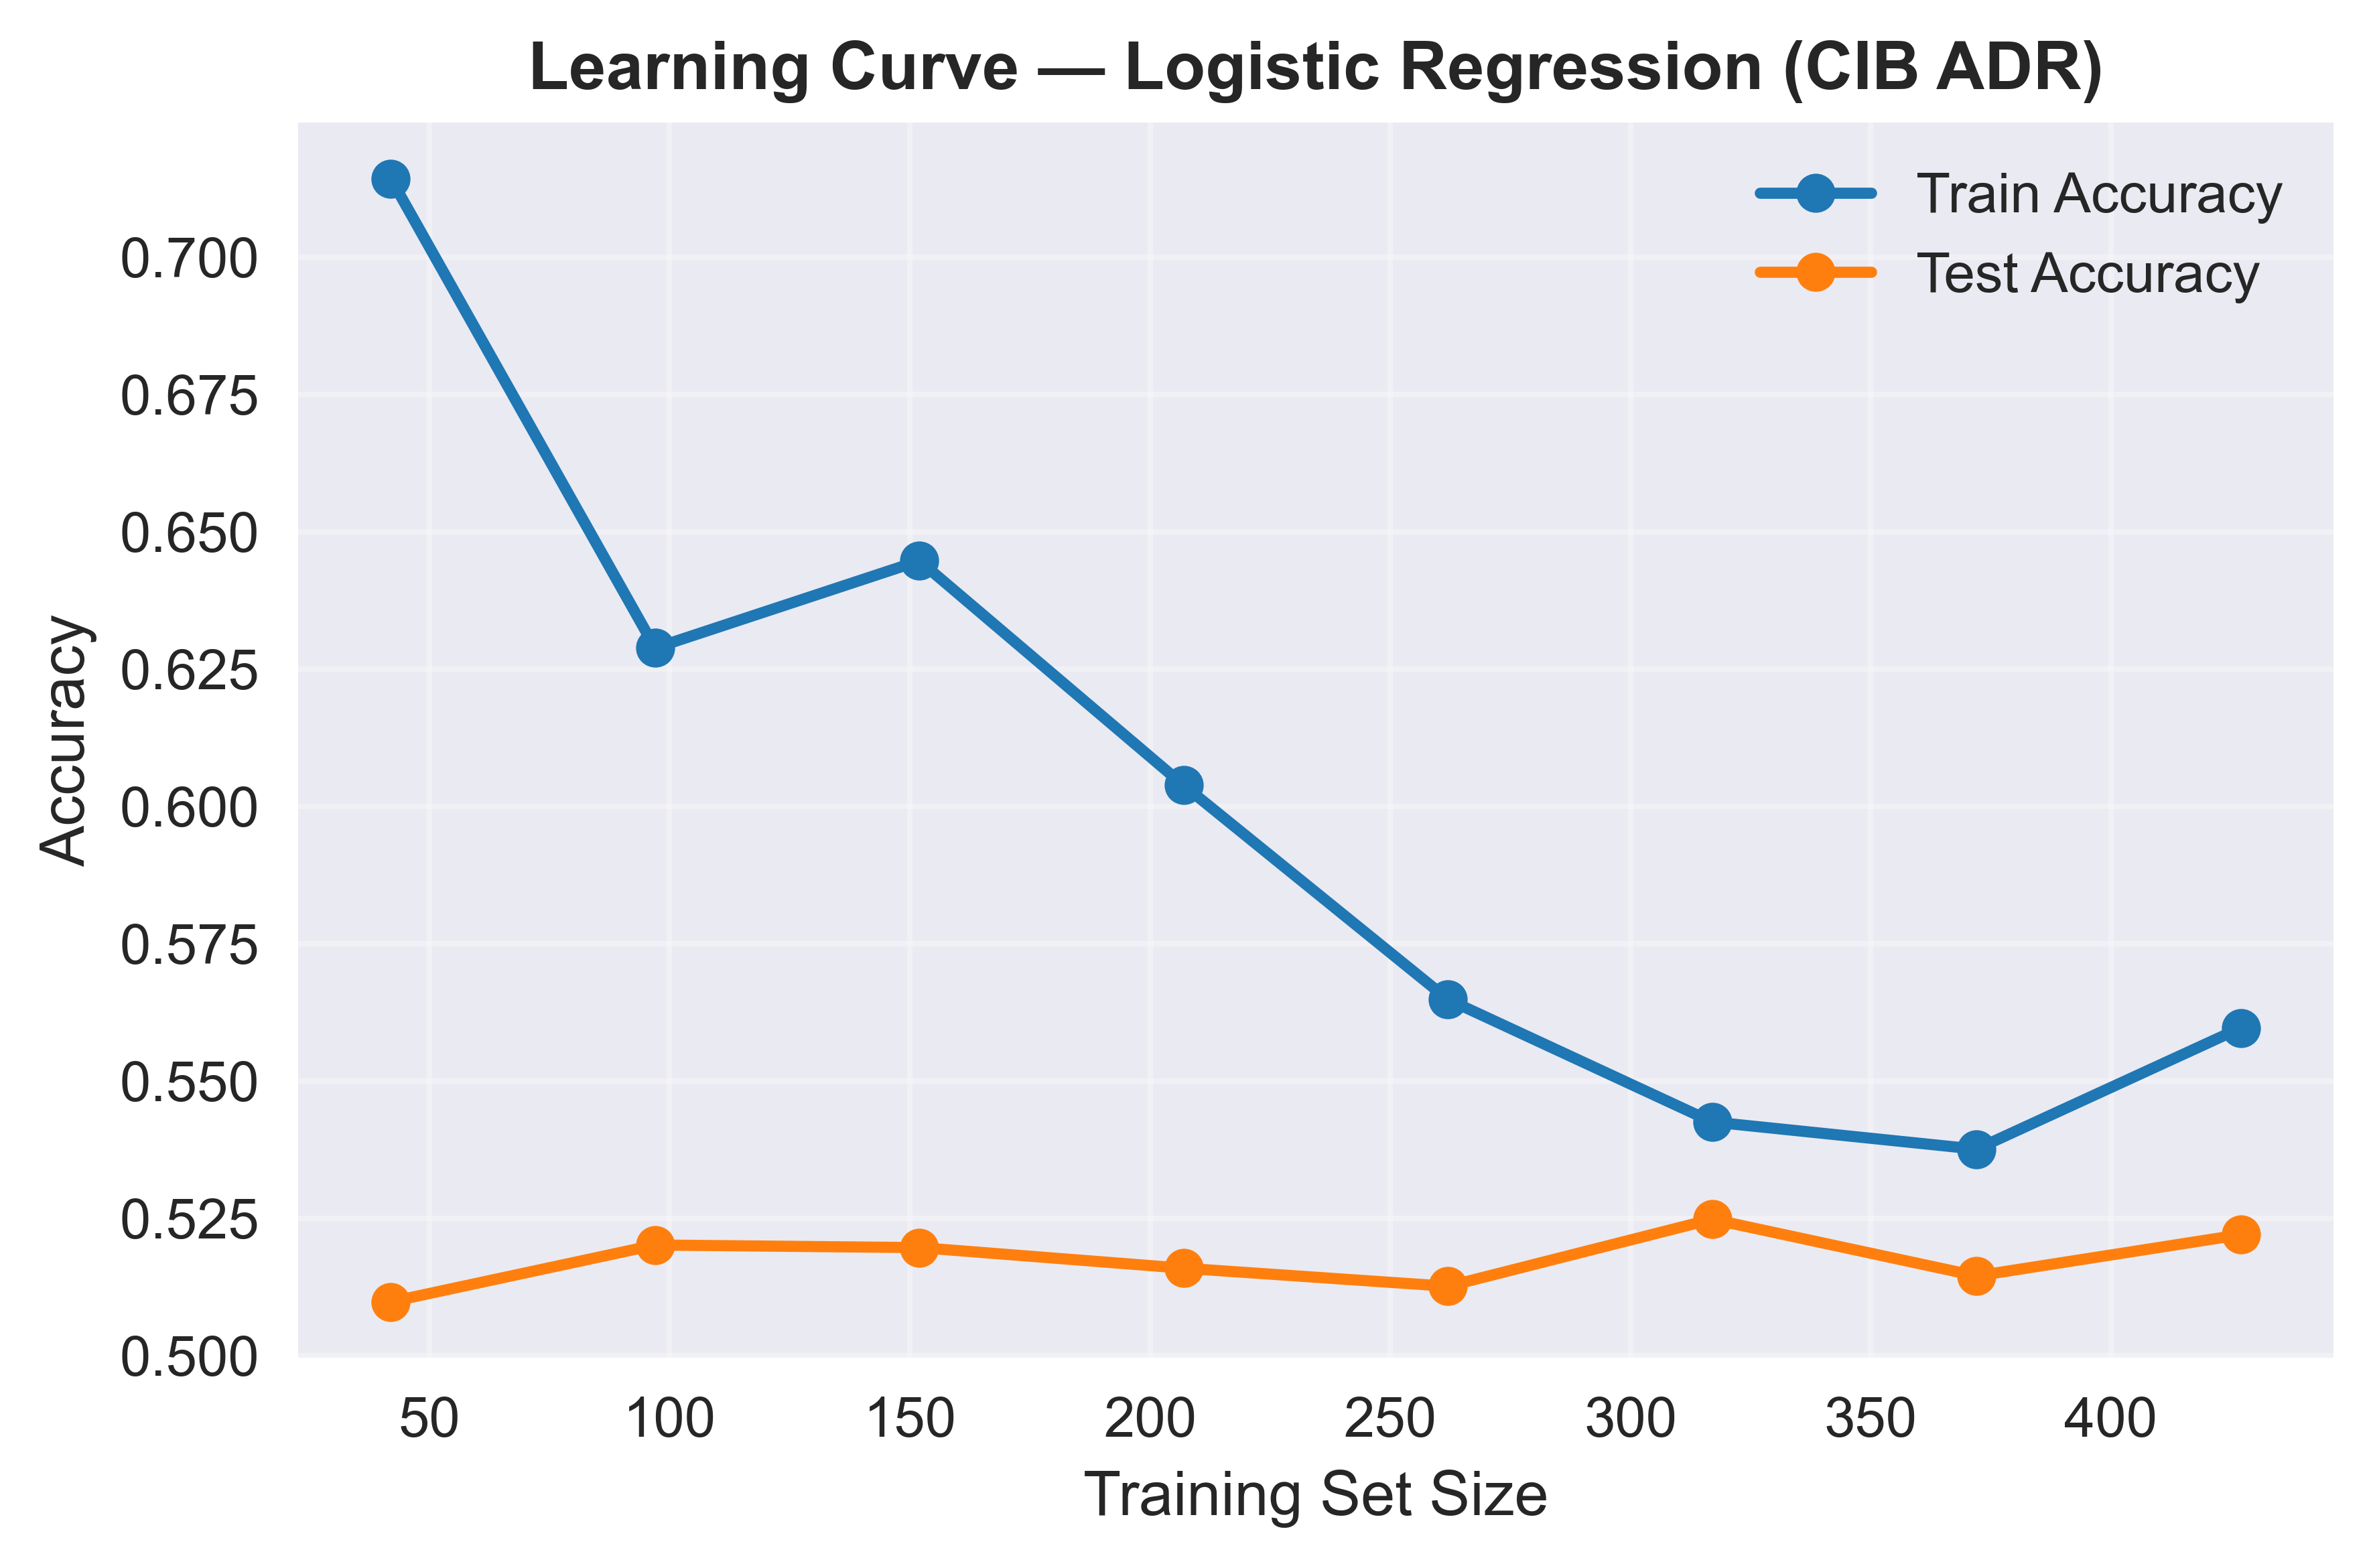

In [10]:
# ==============================================================
# 6.  Learning Curve (Logistic Regression, CIB ADR)
# ==============================================================

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve, TimeSeriesSplit

# --------------------------------------------------------------
# 1. Prepare data
# --------------------------------------------------------------
df_t["Target"] = (df_t["Return_1d"].shift(-1) > 0).astype(int)
df_t.dropna(inplace=True)

features = ["Return_1d", "VolChange", "Return_5d", "Volatility_5d"]
X = df_t[features].values
y = df_t["Target"].values

# Time-series-aware cross-validation (no leakage)
tscv = TimeSeriesSplit(n_splits=5)

# --------------------------------------------------------------
# 2. Model pipeline
# --------------------------------------------------------------
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=2000)
)

# --------------------------------------------------------------
# 3. Compute learning curve
# --------------------------------------------------------------
sizes, tr, te = learning_curve(
    model,
    X, y,
    cv=tscv,
    train_sizes=np.linspace(0.1, 1.0, 8),
    n_jobs=-1,
    scoring='accuracy'
)

# --------------------------------------------------------------
# 4. Plot
# --------------------------------------------------------------
plt.figure(figsize=(6, 4), dpi=300)
plt.plot(sizes, tr.mean(axis=1), marker='o', label='Train Accuracy', color='tab:blue', linewidth=2)
plt.plot(sizes, te.mean(axis=1), marker='o', label='Test Accuracy', color='tab:orange', linewidth=2)
plt.legend(frameon=False)
plt.xlabel('Training Set Size', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.title(f'Learning Curve — Logistic Regression ({ticker} ADR)', fontsize=12, weight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### *Takeaway:*
Even though Logistic Regression is simple, stable, and interpretable, it saturates quickly on financial data.
Beyond a few hundred samples, performance plateaus because the feature space doesn’t represent underlying dynamics.
This motivates moving to deep neural networks, which learn features automatically — capturing complex dependencies between returns, volatility, and volume.

## Residuals under mis-specification

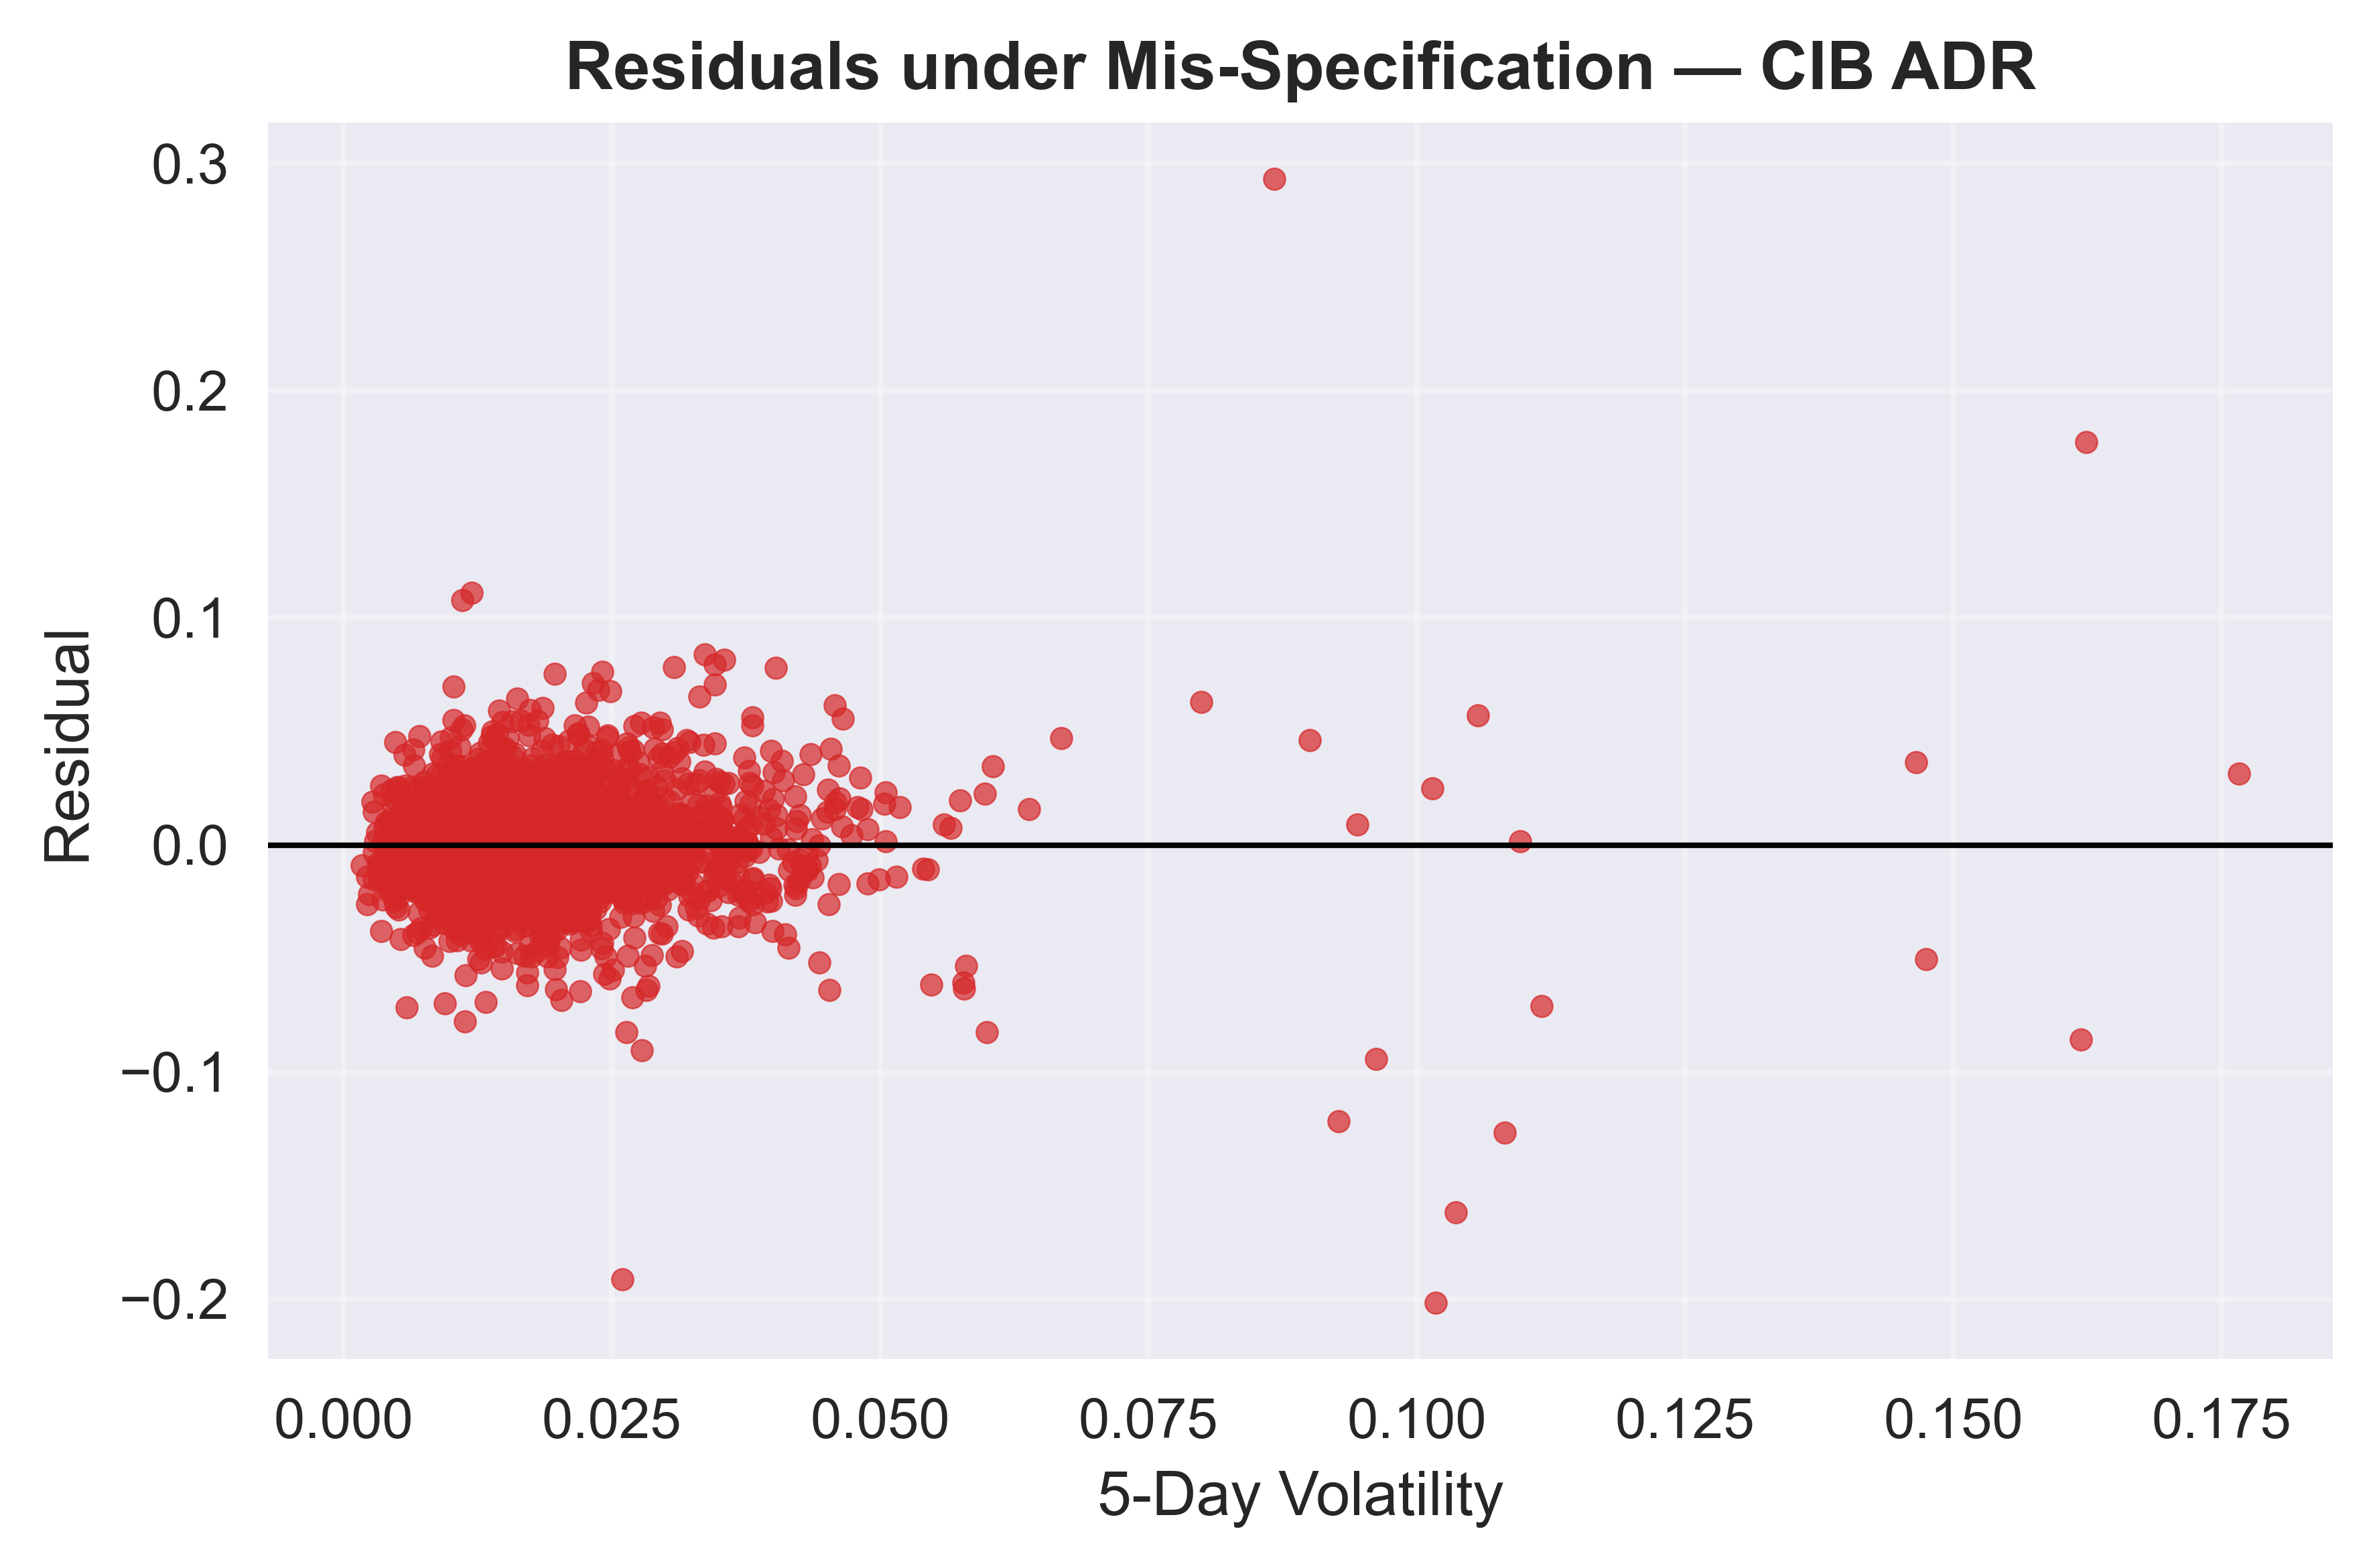

In [11]:
# --------------------------------------------------------------
# ADR version — residuals of linear mis-specification
# --------------------------------------------------------------
from sklearn.linear_model import LinearRegression

# Predictor: Volatility_5d, Target: next-day Return
df_t["Target"] = df_t["Return_1d"].shift(-1)
df_t.dropna(inplace=True)

X = df_t[["Volatility_5d"]].values
y = df_t["Target"].values

model = LinearRegression().fit(X, y)
resid = y - model.predict(X)

plt.figure(figsize=(6, 4), dpi=300)
plt.scatter(df_t["Volatility_5d"], resid, s=15, color='tab:red', alpha=0.7)
plt.axhline(0, color='k', lw=1)
plt.xlabel("5-Day Volatility", fontsize=11)
plt.ylabel("Residual", fontsize=11)
plt.title(f"Residuals under Mis-Specification — {ticker} ADR", fontsize=12, weight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Plot Interpretation:
- The residuals fan out as volatility increases, revealing heteroskedasticity and model mis-specification.
- The linear model fails to capture the non-linear dependence between expected returns and volatility, producing structured residuals rather than white noise.
- This provides a concrete visual motivation for non-linear or deep learning models in subsequent chapters, which can model these conditional dependencies directly.